<a href="https://colab.research.google.com/github/ehcdc1967/Proyectos-de-Inversion/blob/main/Modelo_Random_Forest_con_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV

In [2]:
# 1. Carga de datos
df = pd.read_parquet('https://raw.githubusercontent.com/ehcdc1967/Proyectos-de-Inversion/main/poblacion.parquet')

In [3]:
# 2. Limpieza de datos
df.drop(columns=['CODIGO_UNICO','RATIO_ET_VIABLE','RATIO_ET_COSTO'], inplace=True, errors='ignore')

In [4]:
# Identificar columnas categóricas
columns_to_encode = [col for col in ['FUNCION', 'DPTO', 'TIPO_MUNICIPALIDAD'] if col in df.columns]

if columns_to_encode:
    df[columns_to_encode] = df[columns_to_encode].astype(str).fillna('Unknown')
    df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)


In [5]:
# Verificar si la variable objetivo está presente
if 'SOBRECOSTO' not in df.columns:
    raise ValueError("La columna objetivo 'SOBRECOSTO' no está en el conjunto de datos.")


In [6]:
# Separar características y variable objetivo
X, y = df.drop(columns=['SOBRECOSTO']), df['SOBRECOSTO']

In [7]:
# 3. Normalización con MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [8]:
# 4. Configuración de validación cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

In [9]:
# 5. Función para evaluar el modelo
def evaluar_modelo(modelo, X, y, descripcion):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv_results = cross_validate(modelo, X, y, scoring=scoring, cv=kf, return_train_score=False)

    resultados = {metrica: abs(np.mean(cv_results[f'test_{metrica}'])) for metrica in scoring}

    print(f"\n=== Resultados {descripcion} ===")
    for metrica, valor in resultados.items():
        print(f"{metrica.capitalize()} promedio: {valor:.4f}")

    return resultados


In [10]:
# 6. Entrenamiento del modelo Random Forest con datos desbalanceados
modelo_desbalanceado = RandomForestClassifier(
      random_state = 2024
     ,n_estimators = 100
     ,max_depth    = 10
     ,class_weight = 'balanced'
     )
modelo_desbalanceado.fit(X, y)
resultados_desbalanceado = evaluar_modelo(modelo_desbalanceado, X, y, "Modelo Desbalanceado")



=== Resultados Modelo Desbalanceado ===
Accuracy promedio: 0.8445
Precision promedio: 0.6550
Recall promedio: 0.8259
F1 promedio: 0.7306


In [11]:
# 7. Balanceo de datos con SMOTE
X_balanced, y_balanced = SMOTE(random_state=2024).fit_resample(X, y)


In [12]:
# 8. Entrenamiento del modelo Random Forest con datos balanceados
modelo_balanceado = RandomForestClassifier(
      random_state = 2024
     ,n_estimators = 100
     ,max_depth    = 10
      )
modelo_balanceado.fit(X_balanced, y_balanced)
resultados_balanceado = evaluar_modelo(modelo_balanceado, X_balanced, y_balanced, "Modelo Balanceado")


=== Resultados Modelo Balanceado ===
Accuracy promedio: 0.8623
Precision promedio: 0.8539
Recall promedio: 0.8741
F1 promedio: 0.8639


In [13]:
# 9. Comparación de Importancia de Variables
importances_desbalanceado = modelo_desbalanceado.feature_importances_
importances_balanceado    = modelo_balanceado.feature_importances_
feature_names = df.drop(columns=['SOBRECOSTO']).columns

# Convertir a DataFrame para mejor visualización
feature_importance_df = pd.DataFrame({
     'Variable'                 : feature_names
    ,'Importancia Desbalanceado': importances_desbalanceado
    ,'Importancia Balanceado'   : importances_balanceado
})

# Ordenar por importancia en el modelo desbalanceado y seleccionar las 20 variables más importantes
feature_importance_df = feature_importance_df.sort_values(by='Importancia Desbalanceado', ascending=False).head(20)

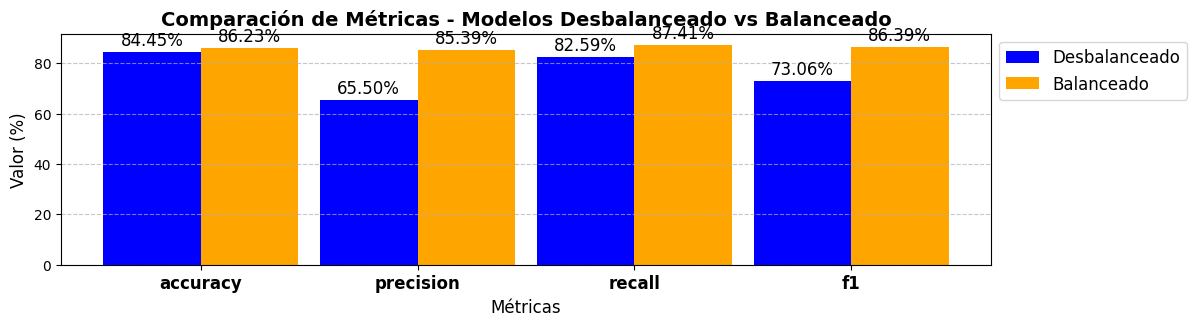

In [14]:
# 10. Gráfico de comparación de métricas (accuracy, precision, recall, f1) con valores en negrita sobre las barras
metricas           = ['accuracy', 'precision', 'recall', 'f1']
desbalanceado_vals = [resultados_desbalanceado[m] * 100 for m in metricas]  # Convertir a porcentaje
balanceado_vals    = [resultados_balanceado[m]    * 100 for m in metricas]  # Convertir a porcentaje

# Generar nuevamente el gráfico con la leyenda a un costado y etiquetas más grandes y en negrita
fig, ax = plt.subplots(figsize=(12,3))
x       = np.arange(len(metricas))
width   = 0.45
bars1   = ax.bar(x - width/2, desbalanceado_vals, width, label='Desbalanceado', color='blue')
bars2   = ax.bar(x + width/2, balanceado_vals   , width, label='Balanceado', color='orange')
ax.set_xlabel('Métricas', fontsize=12 , ) # fontweight='bold'
ax.set_ylabel('Valor (%)', fontsize=12, ) # fontweight='bold'
ax.set_title('Comparación de Métricas - Modelos Desbalanceado vs Balanceado', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=0, fontsize=12, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
# Agregar valores en porcentaje sobre las barras en negrita y más grandes
for bar in bars1 + bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{bar.get_height():.2f}%", ha='center', va='bottom', fontsize=12, color='black')# , fontweight='bold'
plt.show()


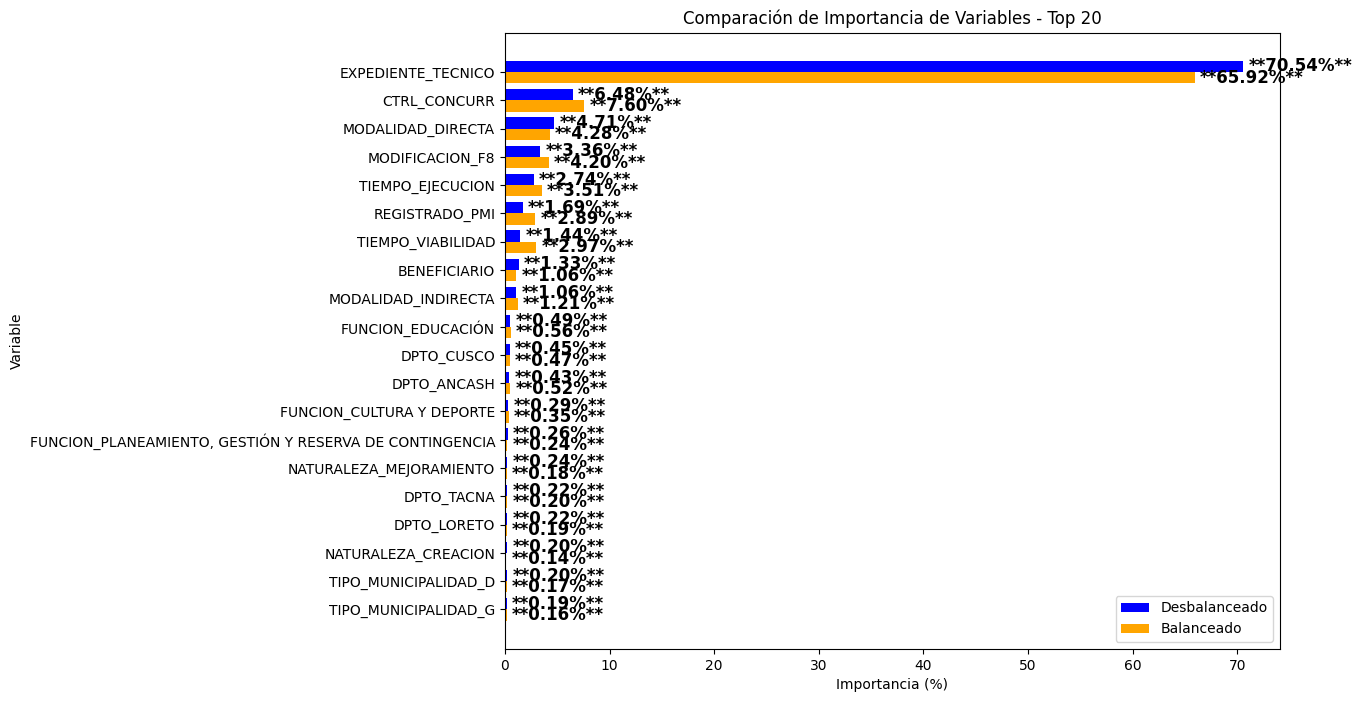

In [15]:
# 11. Gráfico de comparación de importancia de variables (Top 20) con valores en negrita sobre las barras
fig, ax = plt.subplots(figsize=(10, 8))
x = np.arange(len(feature_importance_df))

bars1 = ax.barh(x - 0.2, feature_importance_df['Importancia Desbalanceado'] * 100, 0.4, label='Desbalanceado', color='blue')
bars2 = ax.barh(x + 0.2, feature_importance_df['Importancia Balanceado'] * 100, 0.4, label='Balanceado', color='orange')

ax.set_xlabel("Importancia (%)")
ax.set_ylabel("Variable")
ax.set_title("Comparación de Importancia de Variables - Top 20")
ax.set_yticks(x)
ax.set_yticklabels(feature_importance_df['Variable'])
ax.invert_yaxis()  # La variable más importante arriba
ax.legend()

# Agregar valores en las barras con negrita
for bar in bars1 + bars2:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f"**{bar.get_width():.2f}%**",
            ha='left', va='center', fontsize=12, fontweight='bold', color='black')

plt.show()

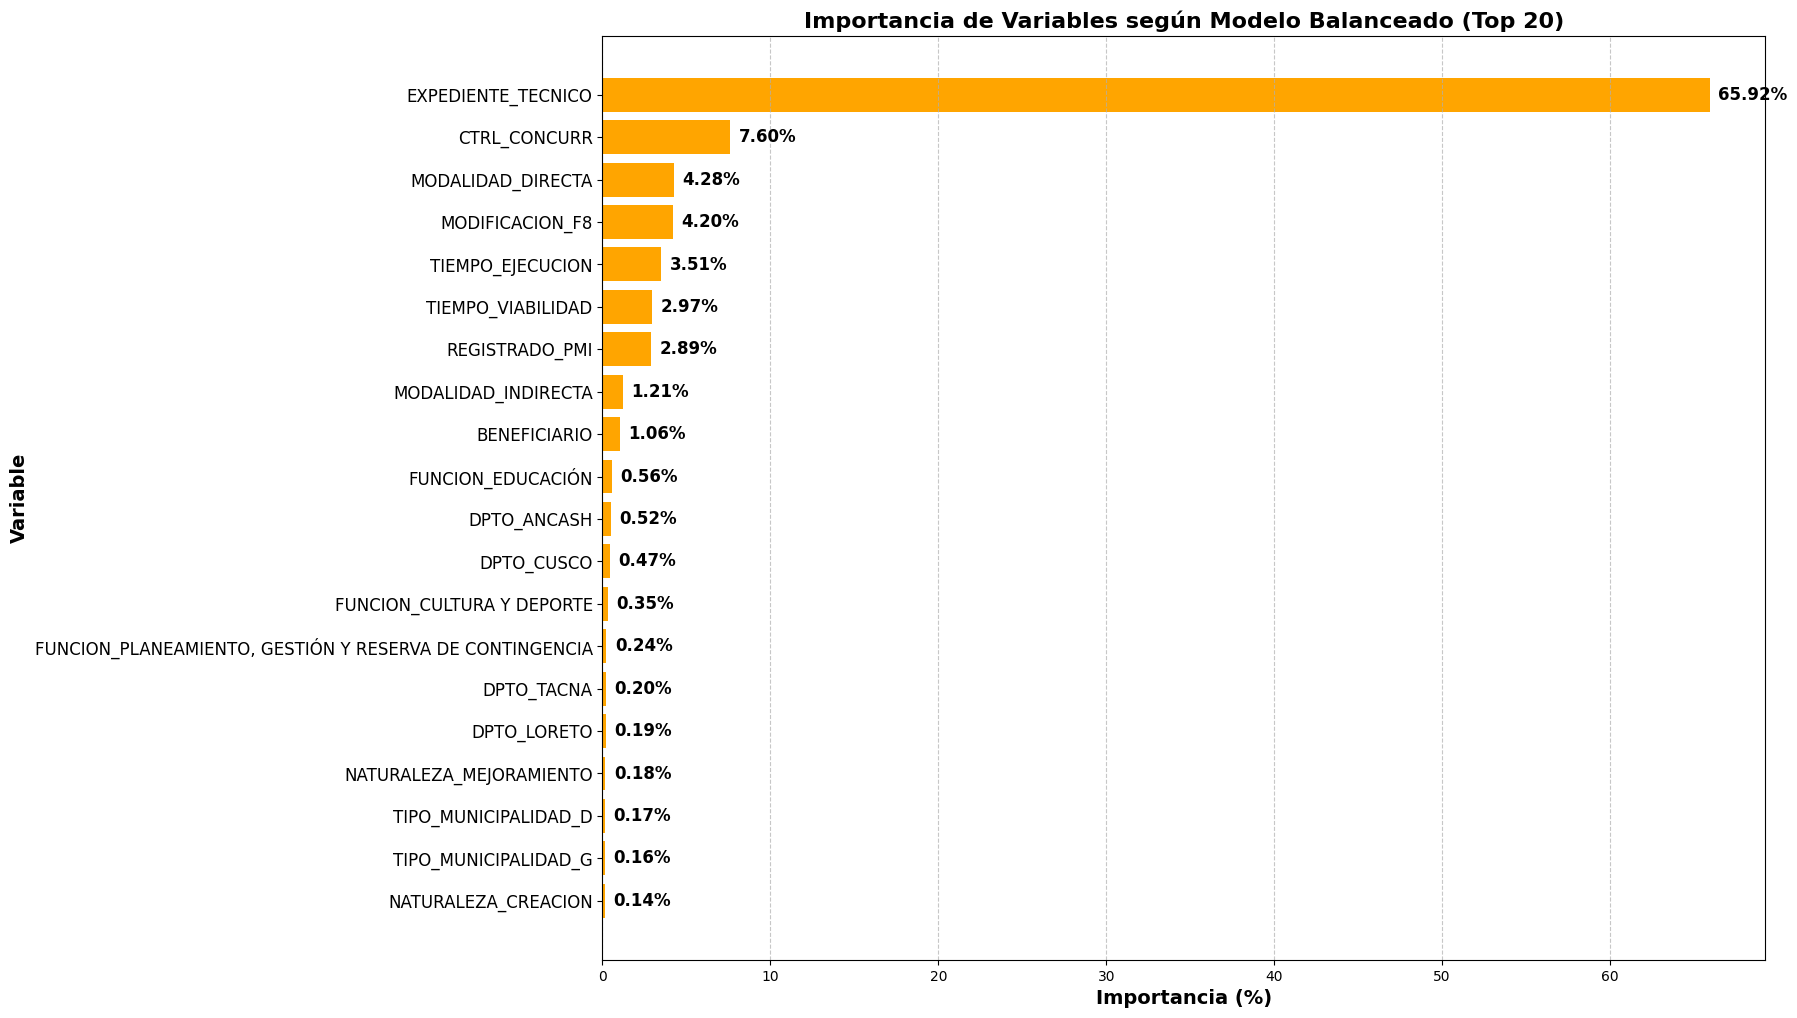

In [16]:
# 12. Gráfico de comparación de importancia de variables (Top 20) con valores en negrita sobre las barras
# Ordenar las variables por importancia en el modelo balanceado y seleccionar las 20 más importantes
feature_importance_df = feature_importance_df.sort_values(by='Importancia Balanceado', ascending=False).head(20)
# Gráfico de importancia de variables solo para el modelo balanceado (Top 20)
fig, ax = plt.subplots(figsize=(15,12))
x = np.arange(len(feature_importance_df))
bars = ax.barh(x, feature_importance_df['Importancia Balanceado'] * 100, color='orange')
# Etiquetas y títulos mejorados
ax.set_xlabel("Importancia (%)", fontsize=14, fontweight='bold', color='black')
ax.set_ylabel("Variable", fontsize=14, fontweight='bold', color='black')
ax.set_title("Importancia de Variables según Modelo Balanceado (Top 20)", fontsize=16, fontweight='bold', color='black')
# Ajustar etiquetas del eje Y
ax.set_yticks(x)
ax.set_yticklabels(feature_importance_df['Variable'], fontsize=12)
ax.invert_yaxis()  # Asegurar que la variable más importante esté arriba
# Agregar una cuadrícula ligera para mejorar la legibilidad
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
# Agregar valores en las barras con negrita
for bar in bars:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.2f}%", ha='left', va='center', fontsize=12, fontweight='bold', color='black')
plt.show()

In [17]:
# 13. Optimización de hiperparámetros con GridSearchCV
param_grid = {
     'n_estimators'     : [100, 200, 300]
    ,'max_depth'        : [10, 15, 20]
    ,'min_samples_split': [2, 5, 10]
    ,'min_samples_leaf' : [1, 2, 4]
}

modelo_rf   = RandomForestClassifier(random_state=2024)
grid_search = GridSearchCV(modelo_rf, param_grid, cv=kf, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_balanced, y_balanced)

mejor_modelo = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [18]:
# 14. Evaluación del modelo optimizado
resultados_optimizado = evaluar_modelo(mejor_modelo, X_balanced, y_balanced, "Modelo Balanceado Optimizado")



=== Resultados Modelo Balanceado Optimizado ===
Accuracy promedio: 0.8826
Precision promedio: 0.8640
Recall promedio: 0.9082
F1 promedio: 0.8856


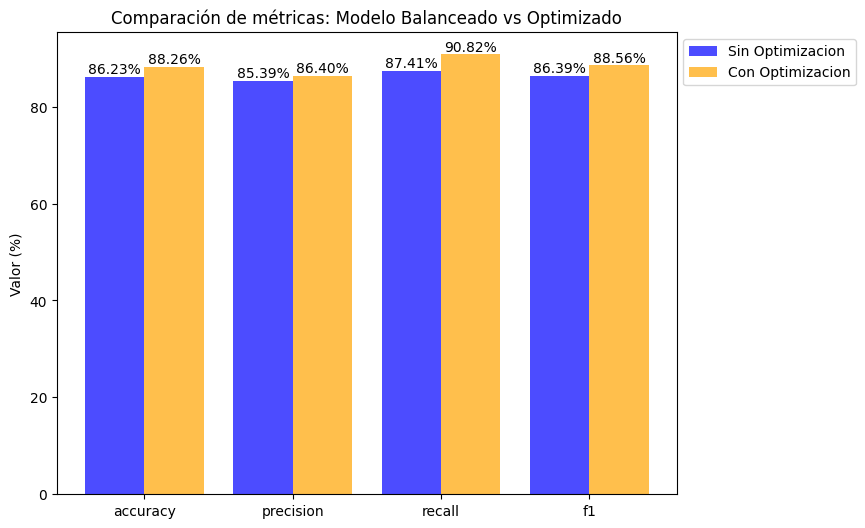

In [19]:
# 15. Gráfico de comparación de métricas
metricas           = ['accuracy', 'precision', 'recall', 'f1']
valores_balanceado = [resultados_balanceado[m] * 100 for m in metricas]
valores_optimizado = [resultados_optimizado[m] * 100 for m in metricas]

x = np.arange(len(metricas))  # Posición de las métricas

# Crear el gráfico de comparación de métricas con valores sobre las barras
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - 0.2, valores_balanceado, width=0.4, label='Sin Optimizacion', color='blue', alpha=0.7)
bars2 = plt.bar(x + 0.2, valores_optimizado, width=0.4, label='Con Optimizacion', color='orange', alpha=0.7)
# Agregar los valores sobre las barras
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, color='black')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, color='black')
# Configurar etiquetas y título
plt.xticks(ticks=x, labels=metricas)
plt.ylabel("Valor (%)")
plt.title("Comparación de métricas: Modelo Balanceado vs Optimizado")
plt.legend()
# Mover la leyenda al lado izquierdo
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
# Mostrar el gráfico
plt.show()


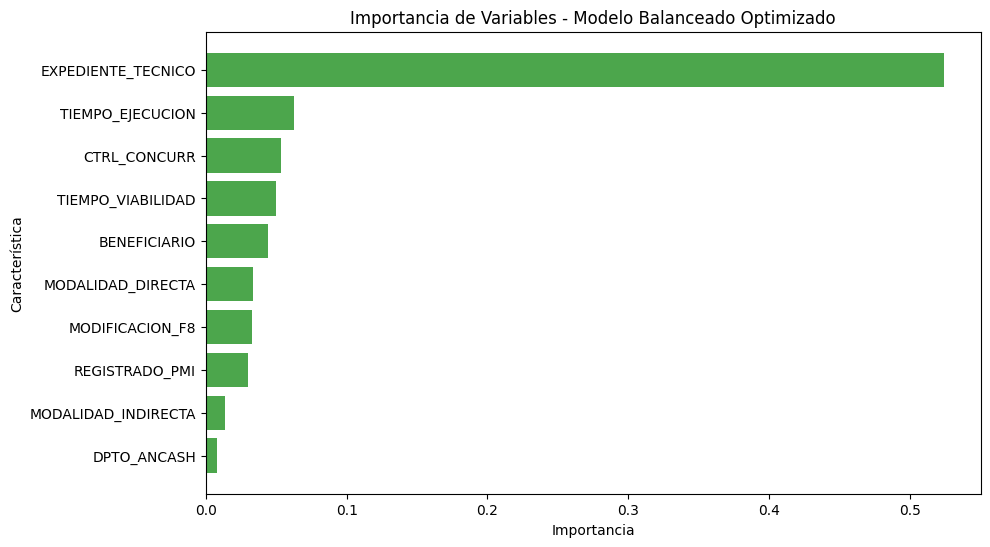

In [20]:
# 16. Gráfico de importancia de características
importances = mejor_modelo.feature_importances_
feature_names = df.drop(columns=['SOBRECOSTO']).columns

sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = np.array(feature_names)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], sorted_importances[:10], color='green', alpha=0.7)
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.title("Importancia de Variables - Modelo Balanceado Optimizado")
plt.gca().invert_yaxis()

plt.show()

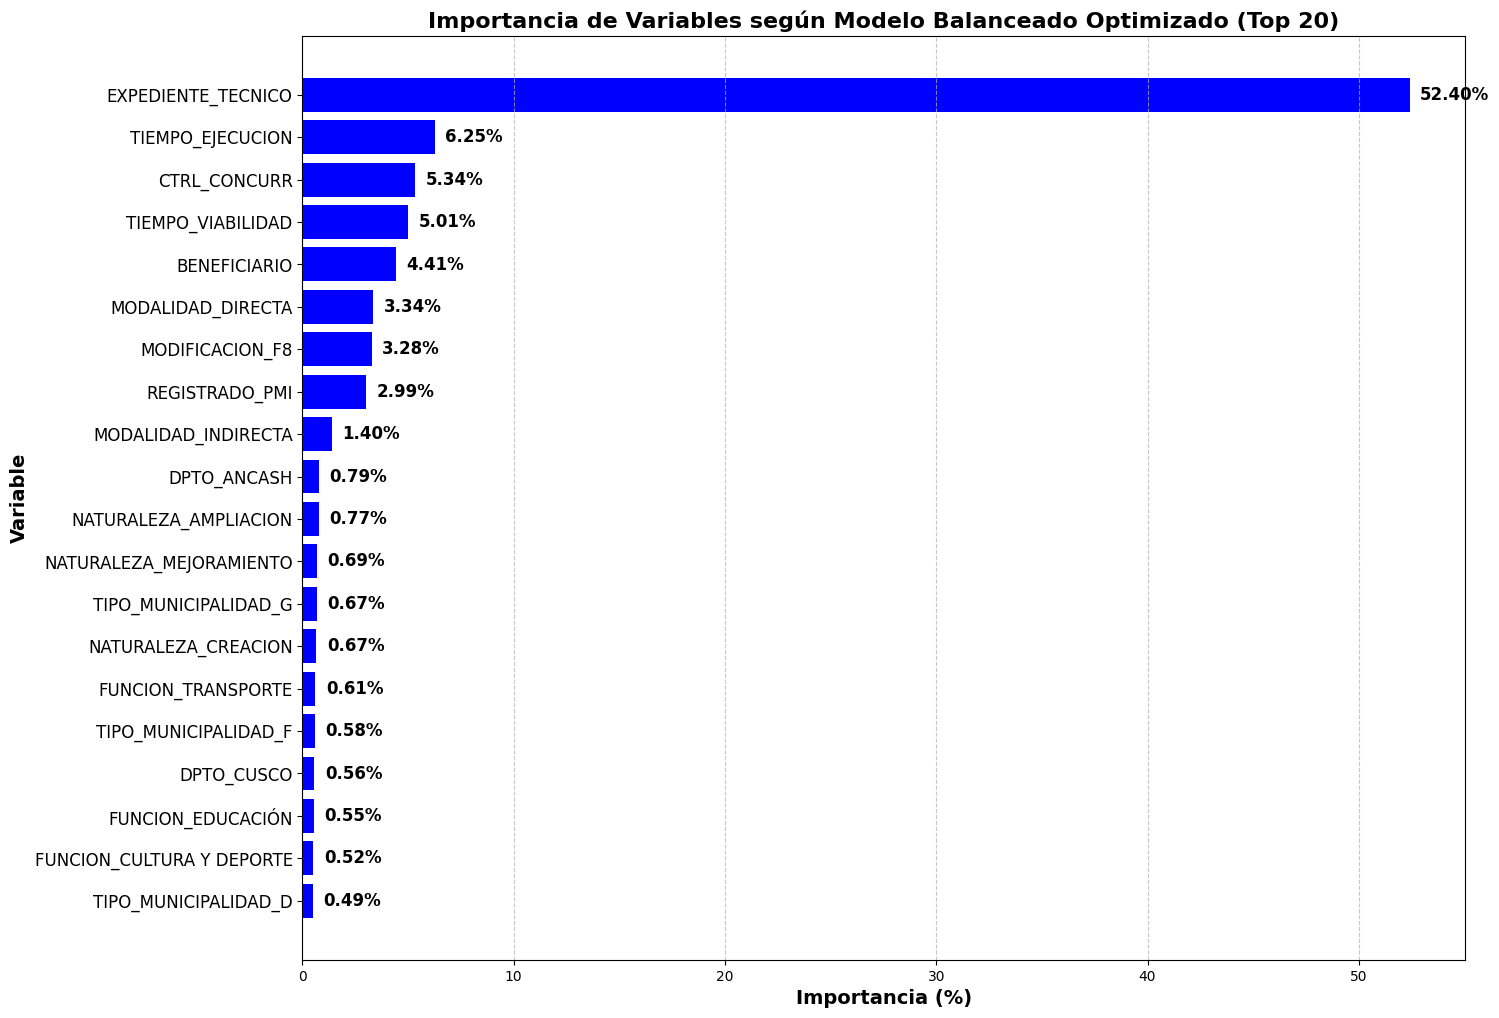

In [22]:
# 17. Gráfico de comparación de importancia de variables (Top 20) con valores en negrita sobre las barras

# Obtener importancias de variables del mejor modelo optimizado
importances = mejor_modelo.feature_importances_

# Crear un DataFrame con las importancias
feature_importance_df = pd.DataFrame({
    'Variable': df.drop(columns=['SOBRECOSTO']).columns,  # Excluir la variable objetivo
    'Importancia': importances
})

# Ordenar las variables por importancia en el modelo optimizado y seleccionar las 20 más importantes
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False).head(20)

# Gráfico de importancia de variables según el modelo balanceado optimizado (Top 20)
fig, ax = plt.subplots(figsize=(15, 12))
x = np.arange(len(feature_importance_df))
bars = ax.barh(x, feature_importance_df['Importancia'] * 100, color='blue')

# Etiquetas y títulos mejorados
ax.set_xlabel("Importancia (%)", fontsize=14, fontweight='bold', color='black')
ax.set_ylabel("Variable", fontsize=14, fontweight='bold', color='black')
ax.set_title("Importancia de Variables según Modelo Balanceado Optimizado (Top 20)", fontsize=16, fontweight='bold', color='black')

# Ajustar etiquetas del eje Y
ax.set_yticks(x)
ax.set_yticklabels(feature_importance_df['Variable'], fontsize=12)
ax.invert_yaxis()  # Asegurar que la variable más importante esté arriba

# Agregar una cuadrícula ligera para mejorar la legibilidad
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Agregar valores en las barras con negrita
for bar in bars:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f"{bar.get_width():.2f}%", ha='left', va='center',
            fontsize=12, fontweight='bold', color='black')

# Mostrar el gráfico
plt.show()